In [ ]:
!pip install scanpy

In [1]:
import scanpy as sc

In [2]:
adata = sc.read_csv('raw_counts/GSM5226574_C51ctr_raw_counts.csv').T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [6]:
adata.X.shape

(6099, 34546)

# Doublet removal - optional but preferred

In [ ]:
!pip install scvi-tools

In [2]:
import scvi

Global seed set to 0


In [12]:
adata

AnnData object with n_obs × n_vars = 6099 × 2000
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [9]:
sc.pp.filter_genes(adata, min_cells = 10)

In [11]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

In [13]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE

Epoch 1/400:   0%|                                      | 0/400 [00:00<?, ?it/s]

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:61: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/jrlab2019/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 400/400: 100%|███████| 400/400 [01:47<00:00,  3.71it/s, loss=323, v_num=1]


In [14]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 207/400:  52%|██▌  | 207/400 [00:52<00:48,  3.97it/s, loss=0.292, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.295. Signaling Trainer to stop.


In [19]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

df.index = df.index.map(lambda x: x[:-2])

df

,doublet,singlet,prediction
TAGGTACCATGGCCAC-1_1,1.191838,-0.571009,doublet
ATTCACTGTAACAGGC-1_1,2.390467,-1.882622,doublet
TAACTTCCAACCACGC-1_1,0.935433,-0.069699,doublet
TTGGGTACACGACAAG-1_1,1.664259,-0.890675,doublet
AGGCCACAGAGTCACG-1_1,1.412867,-0.842290,doublet
...,...,...,...
CGCCATTGTTTGCCGG-1_1,-0.854187,1.234452,singlet
CACTGGGGTCTACGTA-1_1,-2.773367,2.721056,singlet
CATACTTGTAGAGGAA-1_1,-2.752465,2.904153,singlet
TTTGGTTTCCACGGAC-1_1,-3.266799,2.562163,singlet


In [20]:
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,1226,1226
singlet,4873,4873


In [21]:
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1_1,1.191838,-0.571009,doublet,1.762847
ATTCACTGTAACAGGC-1_1,2.390467,-1.882622,doublet,4.273089
TAACTTCCAACCACGC-1_1,0.935433,-0.069699,doublet,1.005132
TTGGGTACACGACAAG-1_1,1.664259,-0.890675,doublet,2.554934
AGGCCACAGAGTCACG-1_1,1.412867,-0.842290,doublet,2.255158
...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,-0.854187,1.234452,singlet,-2.088638
CACTGGGGTCTACGTA-1_1,-2.773367,2.721056,singlet,-5.494422
CATACTTGTAGAGGAA-1_1,-2.752465,2.904153,singlet,-5.656618
TTTGGTTTCCACGGAC-1_1,-3.266799,2.562163,singlet,-5.828962


In [3]:
import seaborn as sns

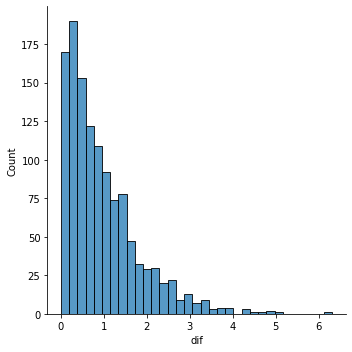

In [23]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [24]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
doublets

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1_1,1.191838,-0.571009,doublet,1.762847
ATTCACTGTAACAGGC-1_1,2.390467,-1.882622,doublet,4.273089
TAACTTCCAACCACGC-1_1,0.935433,-0.069699,doublet,1.005132
TTGGGTACACGACAAG-1_1,1.664259,-0.890675,doublet,2.554934
AGGCCACAGAGTCACG-1_1,1.412867,-0.842290,doublet,2.255158
...,...,...,...,...
GGGTATTTCAGCGCAC-1_1,0.871121,-0.565675,doublet,1.436796
TTGCTGCAGTGCGACA-1_1,0.965060,-0.778612,doublet,1.743671
TACAACGGTTGACTAC-1_1,0.471322,-0.772615,doublet,1.243937
CATCCCAAGACGCCAA-1_1,0.769800,-0.536361,doublet,1.306161


In [26]:
adata = sc.read_csv('raw_counts/GSM5226574_C51ctr_raw_counts.csv').T

In [29]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)

In [30]:
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,True
ATTCACTGTAACAGGC-1_1,True
TAACTTCCAACCACGC-1_1,True
TTGGGTACACGACAAG-1_1,True
AGGCCACAGAGTCACG-1_1,True
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [31]:
adata = adata[~adata.obs.doublet]

In [32]:
adata

View of AnnData object with n_obs × n_vars = 5639 × 34546
    obs: 'doublet'

# Preprocessing

In [35]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')

/tmp/ipykernel_18298/310233584.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-')


In [36]:
adata.var

,mt
AL627309.1,False
AL627309.5,False
AL627309.4,False
AL669831.2,False
LINC01409,False
...,...
VN1R2,False
AL031676.1,False
SMIM34A,False
AL050402.1,False


In [4]:
import pandas as pd

In [38]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

In [39]:
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [41]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [46]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TTACCGCCACTCAGAT-1_1,False,4144,11369.0,39.0,0.343038,5.0,0.043979
TTGGTTTTCCTAGCTC-1_1,False,3902,11472.0,463.0,4.035913,13.0,0.113319
ACTTCCGCACAACGCC-1_1,False,4440,9920.0,265.0,2.671371,82.0,0.826613
TGGTAGTTCCCGTGTT-1_1,False,4316,9016.0,308.0,3.416149,97.0,1.075865
TCTATCACAAGGCTTT-1_1,False,3582,8276.0,183.0,2.211213,5.0,0.060416
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [44]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [47]:
adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL445072.1,False,False,0,0.000000,100.000000,0.0
CFC1,False,False,0,0.000000,100.000000,0.0
AMER3,False,False,0,0.000000,100.000000,0.0
LINC01087,False,False,0,0.000000,100.000000,0.0
AC062021.1,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...
AKAP13,False,False,4053,2.895017,28.125554,16325.0
NEAT1,False,False,4141,5.006384,26.564994,28231.0
MBNL1,False,False,4144,2.694981,26.511793,15197.0
ZBTB20,False,False,4276,2.431992,24.170952,13714.0


In [48]:
sc.pp.filter_genes(adata, min_cells=3)

In [49]:
adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
AL117341.1,False,False,3,0.000532,99.946799,3.0,3
CEP83-DT,False,False,3,0.000532,99.946799,3.0,3
TMPO-AS1,False,False,3,0.000532,99.946799,3.0,3
SLC17A8,False,False,3,0.000532,99.946799,3.0,3
PAH,False,False,3,0.000532,99.946799,3.0,3
...,...,...,...,...,...,...,...
AKAP13,False,False,4053,2.895017,28.125554,16325.0,4053
NEAT1,False,False,4141,5.006384,26.564994,28231.0,4141
MBNL1,False,False,4144,2.694981,26.511793,15197.0,4144
ZBTB20,False,False,4276,2.431992,24.170952,13714.0,4276


In [52]:
adata.obs.sort_values('n_genes_by_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TAGGGTTTCTGGCTGG-1_1,False,276,419.0,1.0,0.238663,1.0,0.238663
CGTGCTTCAAAGGGCT-1_1,False,277,432.0,41.0,9.490741,0.0,0.000000
TGACAGTTCTAAACGC-1_1,False,278,414.0,0.0,0.000000,0.0,0.000000
CTCTGGTCACGACGAA-1_1,False,285,407.0,0.0,0.000000,0.0,0.000000
GTAAGTCGTATCGCGC-1_1,False,289,430.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
GCAACCGAGGGCAGGA-1_1,False,3668,7711.0,231.0,2.995720,10.0,0.129685
TTGGTTTTCCTAGCTC-1_1,False,3902,11472.0,463.0,4.035913,13.0,0.113319
TTACCGCCACTCAGAT-1_1,False,4144,11369.0,39.0,0.343038,5.0,0.043979
TGGTAGTTCCCGTGTT-1_1,False,4316,9016.0,308.0,3.416149,97.0,1.075865


In [ ]:
#sc.pp.filter_cells(adata, min_genes=200)

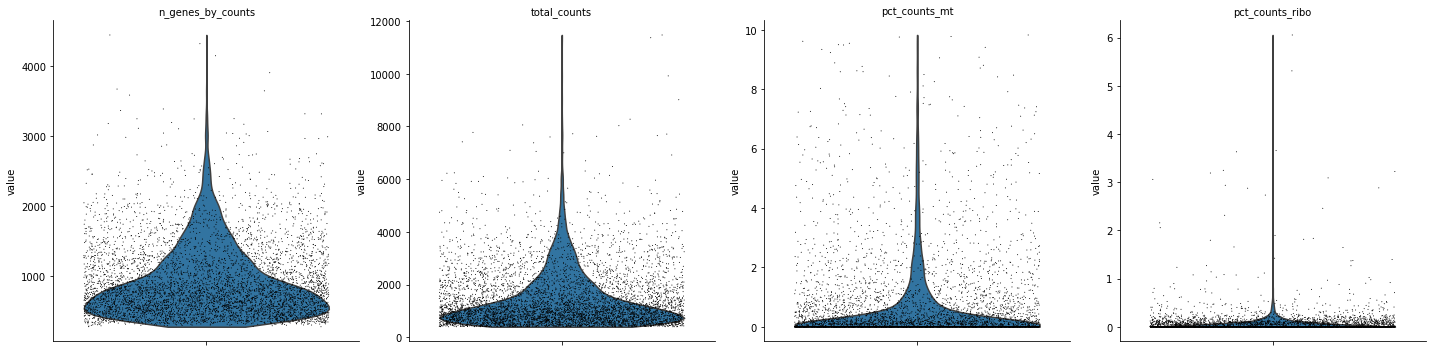

In [53]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [5]:
import numpy as np

In [55]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
#upper_lim = 3000

In [56]:
upper_lim

2305.7199999999993

In [58]:
adata = adata[adata.obs.n_genes_by_counts < upper_lim]

In [59]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
CCTCAACCATACAGGG-1_1,False,2276,5434.0,38.0,0.699301,0.0,0.000000
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161
GGGTCACTCTATTCGT-1_1,False,2286,5056.0,0.0,0.000000,1.0,0.019778
TCATGCCGTCTTTCAT-1_1,False,2234,4993.0,0.0,0.000000,3.0,0.060084
TACATTCGTACGTACT-1_1,False,2253,4776.0,13.0,0.272194,1.0,0.020938
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [60]:
adata = adata[adata.obs.pct_counts_mt < 20]

In [61]:
adata = adata[adata.obs.pct_counts_ribo < 2]

In [62]:
adata

View of AnnData object with n_obs × n_vars = 5509 × 24138
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

# Normalization

In [64]:
adata.X.sum(axis = 1)

ArrayView([5433., 5250., 5050., ...,  410.,  405.,  410.], dtype=float32)

In [65]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [66]:
adata.X.sum(axis = 1)

array([10000., 10000., 10000., ..., 10000., 10000., 10000.], dtype=float32)

In [67]:
sc.pp.log1p(adata) #change to log counts

In [68]:
adata.X.sum(axis = 1)

array([3285.3794, 2858.1602, 3197.6338, ..., 1191.2706, 1022.7512,
       1162.8784], dtype=float32)

In [69]:
adata.raw = adata

# Clustering

In [70]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

In [71]:
adata.var

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,False,False,4,0.000709,99.929065,4.0,4,True,0.009603,2.873558,1.580709
AL627309.5,False,False,25,0.004433,99.556659,25.0,25,False,0.028933,2.310265,-0.122644
AL627309.4,False,False,4,0.000709,99.929065,4.0,4,False,0.002521,1.702826,-1.959491
LINC01409,False,False,235,0.045221,95.832594,255.0,235,False,0.268514,2.327824,-0.069546
FAM87B,False,False,6,0.001064,99.893598,6.0,6,False,0.007229,1.947622,-1.219245
...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,False,False,120,0.021990,97.871963,124.0,120,False,0.158198,2.409560,0.177615
AL592183.1,False,False,870,0.182479,84.571733,1029.0,870,False,0.869866,2.510916,-0.393769
AC240274.1,False,False,142,0.026068,97.481823,147.0,142,False,0.153613,2.299059,-0.156529
AC007325.4,False,False,4,0.000709,99.929065,4.0,4,False,0.003030,1.579819,-2.331452


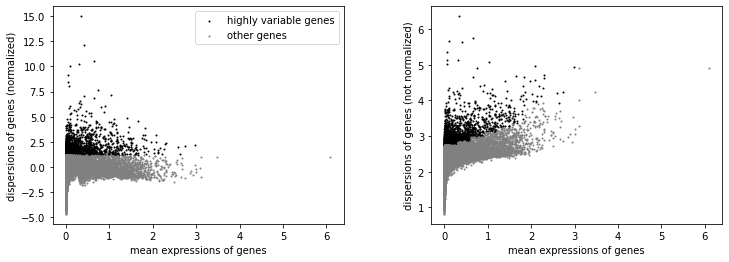

In [72]:
sc.pl.highly_variable_genes(adata)

In [73]:
adata = adata[:, adata.var.highly_variable]

In [75]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

In [76]:
sc.pp.scale(adata, max_value=10)

In [77]:
sc.tl.pca(adata, svd_solver='arpack')

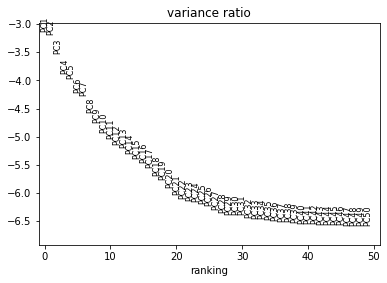

In [78]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [79]:
sc.pp.neighbors(adata, n_pcs = 30)

In [84]:
sc.tl.umap(adata)

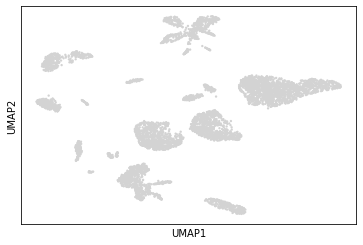

In [85]:
sc.pl.umap(adata)

In [ ]:
#!pip install leidenalg

In [86]:
sc.tl.leiden(adata, resolution = 0.5)

In [87]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,leiden
CCTCAACCATACAGGG-1_1,False,2276,5434.0,38.0,0.699301,0.0,0.000000,10
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161,2
GGGTCACTCTATTCGT-1_1,False,2286,5056.0,0.0,0.000000,1.0,0.019778,2
TCATGCCGTCTTTCAT-1_1,False,2234,4993.0,0.0,0.000000,3.0,0.060084,2
TACATTCGTACGTACT-1_1,False,2253,4776.0,13.0,0.272194,1.0,0.020938,7
...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000,7
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000,1
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000,0
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827,5


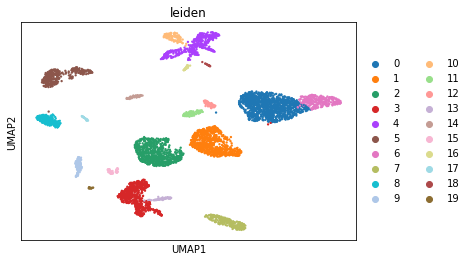

In [88]:
sc.pl.umap(adata, color=['leiden'])

# Integration

In [89]:
def pp(csv_path):
    adata = sc.read_csv(csv_path).T
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    
    adata = sc.read_csv(csv_path).T
    adata.obs['Sample'] = csv_path.split('_')[2] #'raw_counts/GSM5226574_C51ctr_raw_counts.csv'
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]

    return adata

In [90]:
import os

In [92]:
out = []
for file in os.listdir('raw_counts/'):
    out.append(pp('raw_counts/' + file))

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE

Epoch 400/400: 100%|███████| 400/400 [01:18<00:00,  5.07it/s, loss=339, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 142/400:  36%|█▊   | 142/400 [00:24<00:44,  5.82it/s, loss=0.314, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.282. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:19<00:00,  5.02it/s, loss=306, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 274/400:  68%|████  | 274/400 [00:50<00:23,  5.43it/s, loss=0.24, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.222. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [02:06<00:00,  3.16it/s, loss=350, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 147/400:  37%|█▊   | 147/400 [00:44<01:16,  3.30it/s, loss=0.307, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.298. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [00:58<00:00,  6.89it/s, loss=334, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 335/400:  84%|████▏| 335/400 [00:45<00:08,  7.44it/s, loss=0.252, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.273. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:04<00:00,  6.22it/s, loss=354, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 216/400:  54%|██▋  | 216/400 [00:29<00:25,  7.31it/s, loss=0.343, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.348. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:20<00:00,  4.99it/s, loss=397, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 184/400:  46%|██▊   | 184/400 [00:33<00:39,  5.48it/s, loss=0.32, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.294. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:05<00:00,  6.14it/s, loss=336, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 350/400:  88%|████▍| 350/400 [00:53<00:07,  6.57it/s, loss=0.298, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.229. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:44<00:00,  3.83it/s, loss=309, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 251/400:  63%|███▏ | 251/400 [01:00<00:35,  4.16it/s, loss=0.234, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.243. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:42<00:00,  3.89it/s, loss=324, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 209/400:  52%|██▌  | 209/400 [00:52<00:47,  4.00it/s, loss=0.299, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.299. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [00:33<00:00, 11.97it/s, loss=377, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 253/400:  63%|███▏ | 253/400 [00:20<00:11, 12.39it/s, loss=0.307, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.293. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:24<00:00,  4.72it/s, loss=340, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 227/400:  57%|██▊  | 227/400 [00:46<00:35,  4.85it/s, loss=0.355, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.356. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:00<00:00,  6.65it/s, loss=255, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 253/400:  63%|███▏ | 253/400 [00:38<00:22,  6.61it/s, loss=0.281, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.258. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:05<00:00,  6.12it/s, loss=320, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 165/400:  41%|██   | 165/400 [00:26<00:38,  6.17it/s, loss=0.338, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.296. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:59<00:00,  3.34it/s, loss=359, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 231/400:  58%|██▉  | 231/400 [01:09<00:50,  3.34it/s, loss=0.303, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.303. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:20<00:00,  4.96it/s, loss=345, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 154/400:  38%|█▉   | 154/400 [00:28<00:45,  5.38it/s, loss=0.276, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.265. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [00:47<00:00,  8.39it/s, loss=303, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 257/400:  64%|███▏ | 257/400 [00:29<00:16,  8.58it/s, loss=0.196, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.208. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:09<00:00,  5.74it/s, loss=355, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 249/400:  62%|███  | 249/400 [00:41<00:25,  5.96it/s, loss=0.302, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.259. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [00:52<00:00,  7.64it/s, loss=346, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 259/400:  65%|███▏ | 259/400 [00:34<00:18,  7.49it/s, loss=0.325, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.316. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:23<00:00,  4.77it/s, loss=368, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 252/400:  63%|███▏ | 252/400 [00:51<00:29,  4.94it/s, loss=0.289, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.327. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [00:44<00:00,  8.92it/s, loss=419, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 262/400:  66%|███▎ | 262/400 [00:27<00:14,  9.60it/s, loss=0.346, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.352. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:19<00:00,  5.00it/s, loss=289, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 292/400:  73%|███▋ | 292/400 [00:57<00:21,  5.06it/s, loss=0.258, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.245. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [00:27<00:00, 14.39it/s, loss=313, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 278/400:  70%|███▍ | 278/400 [00:18<00:08, 15.11it/s, loss=0.261, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.278. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:00<00:00,  6.56it/s, loss=321, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 224/400:  56%|██▊  | 224/400 [00:31<00:24,  7.20it/s, loss=0.317, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.291. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:19<00:00,  5.04it/s, loss=323, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 237/400:  59%|██▉  | 237/400 [00:44<00:30,  5.33it/s, loss=0.278, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.265. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:25<00:00,  4.67it/s, loss=475, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 241/400:  60%|███  | 241/400 [00:49<00:32,  4.87it/s, loss=0.341, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.339. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:11<00:00,  5.59it/s, loss=326, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 196/400:  49%|██▍  | 196/400 [00:32<00:33,  6.03it/s, loss=0.245, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.235. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if 

Epoch 400/400: 100%|███████| 400/400 [01:59<00:00,  3.35it/s, loss=340, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 163/400:  41%|██   | 163/400 [00:46<01:07,  3.50it/s, loss=0.319, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.312. Signaling Trainer to stop.


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [94]:
adata = sc.concat(out)

In [101]:
adata

AnnData object with n_obs × n_vars = 98979 × 29037
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [100]:
sc.pp.filter_genes(adata, min_cells = 10)

In [102]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [103]:
from scipy.sparse import csr_matrix

In [104]:
adata.X = csr_matrix(adata.X)

In [105]:
adata.X

<98979x29037 sparse matrix of type '<class 'numpy.float32'>'
	with 80634908 stored elements in Compressed Sparse Row format>

In [106]:
adata.write_h5ad('combined.h5ad')

In [ ]:
########################################################

In [1]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

Global seed set to 0


In [2]:
adata = sc.read_h5ad('combined.h5ad')
adata

AnnData object with n_obs × n_vars = 98979 × 29037
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [3]:
adata.obs.groupby('Sample').count()

,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
Sample,,,,,,,,
C51ctr,5414,5414,5414,5414,5414,5414,5414,5414
C52ctr,4062,4062,4062,4062,4062,4062,4062,4062
C53ctr,6114,6114,6114,6114,6114,6114,6114,6114
C54ctr,3937,3937,3937,3937,3937,3937,3937,3937
C55ctr,5107,5107,5107,5107,5107,5107,5107,5107
C56ctr,3655,3655,3655,3655,3655,3655,3655,3655
C57ctr,4303,4303,4303,4303,4303,4303,4303,4303
L01cov,2719,2719,2719,2719,2719,2719,2719,2719
L03cov,3614,3614,3614,3614,3614,3614,3614,3614


In [4]:
sc.pp.filter_genes(adata, min_cells = 100)

In [5]:
adata

AnnData object with n_obs × n_vars = 98979 × 20631
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [6]:
adata.layers['counts'] = adata.X.copy()

In [7]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [8]:
adata.obs.head()

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TTTGACTAGAGCCGAT-1_15,L08cov,False,2576,2576,5714.0,0.0,0.0,1.0,0.017501
TTAGTCTGTATTTCCT-1_15,L08cov,False,2546,2546,5608.0,0.0,0.0,19.0,0.338802
AGGCATTCAGCTACAT-1_15,L08cov,False,2527,2527,5431.0,0.0,0.0,0.0,0.000000
GGTGATTAGAGGATCC-1_15,L08cov,False,2531,2531,5489.0,0.0,0.0,0.0,0.000000
CAGTTCCGTAGCACAG-1_15,L08cov,False,2503,2503,5446.0,0.0,0.0,10.0,0.183621


In [9]:
adata

AnnData object with n_obs × n_vars = 98979 × 20631
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [ ]:
# sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset = True, layer = 'counts',
#                            flavor = "seurat_v3", batch_key="Sample") #no batch_key if one sample

In [10]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

adfsdfsdf
adfsdfsdf
adfsdfsdf
adfsdfsdf


In [11]:
model = scvi.model.SCVI(adata)

In [12]:
model.train() #may take a while without GPU

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE

Epoch 1/81:   0%|                                        | 0/81 [00:00<?, ?it/s]

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:61: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/jrlab2019/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 81/81: 100%|███████| 81/81 [30:11<00:00, 22.36s/it, loss=2.8e+03, v_num=1]


In [15]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [17]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [20]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [21]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

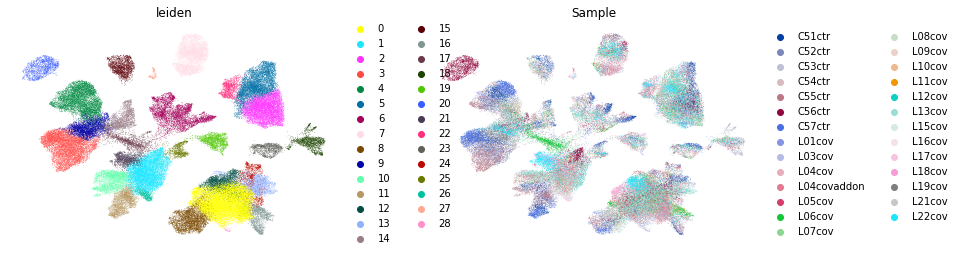

In [50]:
sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)

In [23]:
adata.write_h5ad('integrated.h5ad')

# Find markers/ label cell types

In [49]:
sc.tl.leiden(adata, resolution = 1)

In [51]:
sc.tl.rank_genes_groups(adata, 'leiden')

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: Performanc

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: Performanc

In [26]:
#sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [52]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,CTSB,161.362488,5.018844,0.000000,0.000000
1,0,PLXDC2,139.159439,3.112112,0.000000,0.000000
2,0,LRMDA,138.172195,2.787720,0.000000,0.000000
3,0,FMN1,135.300537,3.722885,0.000000,0.000000
4,0,ZEB2,135.168793,3.297538,0.000000,0.000000
...,...,...,...,...,...,...
578507,28,ISCA1,2.139728,3.488754,0.037089,0.049485
578508,28,KAT8,2.138154,2.494356,0.037222,0.049660
578509,28,PGRMC1,2.137416,4.002601,0.037286,0.049738
578510,28,COX6B1,2.136742,4.314718,0.037344,0.049812


In [53]:
markers_scvi = model.differential_expression(groupby = 'leiden')
markers_scvi

DE...: 100%|████████████████████████████████████| 29/29 [03:39<00:00,  7.59s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
AC013457.1,0.9924,0.0076,4.871977,0.000036,0.000005,0.0,0.25,5.444043,5.759068,2.807112,...,0.044017,0.006554,0.036888,0.005477,0.262174,0.041360,True,0 vs Rest,0,Rest
SPP1,0.9910,0.0090,4.701489,0.000757,0.000030,0.0,0.25,7.256708,7.589929,3.466275,...,1.068512,0.023293,0.179320,0.006530,6.257119,0.186454,True,0 vs Rest,0,Rest
APOC1,0.9900,0.0100,4.595119,0.000151,0.000013,0.0,0.25,7.438905,7.908280,3.706619,...,0.254346,0.017544,0.127483,0.011452,1.277133,0.107620,True,0 vs Rest,0,Rest
MT1H,0.9900,0.0100,4.595119,0.000097,0.000004,0.0,0.25,6.226989,6.242821,3.264459,...,0.026230,0.000639,0.013357,0.000473,0.174182,0.004823,True,0 vs Rest,0,Rest
ASGR1,0.9896,0.0104,4.555494,0.000071,0.000005,0.0,0.25,5.114059,5.205582,2.837578,...,0.108242,0.007098,0.067756,0.005868,0.649141,0.049460,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HNRNPM,0.5920,0.4080,0.372239,0.000151,0.000167,0.0,0.25,-0.102823,-0.087278,0.456335,...,0.188679,0.204692,0.150943,0.174231,1.989113,1.787526,False,28 vs Rest,28,Rest
CLPX,0.5808,0.4192,0.326058,0.000042,0.000047,0.0,0.25,-0.076070,-0.097029,0.509093,...,0.056604,0.055876,0.056604,0.052170,0.442286,0.460094,False,28 vs Rest,28,Rest
KPNA6,0.5776,0.4224,0.312929,0.000077,0.000089,0.0,0.25,-0.188453,-0.170998,0.435172,...,0.037736,0.108809,0.037736,0.097800,0.451274,0.930238,False,28 vs Rest,28,Rest
YME1L1,0.5592,0.4408,0.237916,0.000083,0.000090,0.0,0.25,-0.079504,-0.078418,0.432397,...,0.301887,0.122407,0.245283,0.108364,3.282766,1.031963,False,28 vs Rest,28,Rest


In [55]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > .5)]
markers_scvi

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
AC013457.1,0.9924,0.0076,4.871977,0.000036,0.000005,0.0,0.25,5.444043,5.759068,2.807112,...,0.044017,0.006554,0.036888,0.005477,0.262174,0.041360,True,0 vs Rest,0,Rest
SPP1,0.9910,0.0090,4.701489,0.000757,0.000030,0.0,0.25,7.256708,7.589929,3.466275,...,1.068512,0.023293,0.179320,0.006530,6.257119,0.186454,True,0 vs Rest,0,Rest
APOC1,0.9900,0.0100,4.595119,0.000151,0.000013,0.0,0.25,7.438905,7.908280,3.706619,...,0.254346,0.017544,0.127483,0.011452,1.277133,0.107620,True,0 vs Rest,0,Rest
MT1H,0.9900,0.0100,4.595119,0.000097,0.000004,0.0,0.25,6.226989,6.242821,3.264459,...,0.026230,0.000639,0.013357,0.000473,0.174182,0.004823,True,0 vs Rest,0,Rest
ASGR1,0.9896,0.0104,4.555494,0.000071,0.000005,0.0,0.25,5.114059,5.205582,2.837578,...,0.108242,0.007098,0.067756,0.005868,0.649141,0.049460,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CELSR2,0.9024,0.0976,2.224180,0.000003,0.000003,0.0,0.25,0.781614,0.777556,1.795451,...,0.000000,0.003831,0.000000,0.003740,0.000000,0.031086,True,28 vs Rest,28,Rest
ABCA1,0.9024,0.0976,2.224180,0.000425,0.000444,0.0,0.25,0.819800,0.621356,1.882264,...,0.528302,0.594736,0.320755,0.260356,5.439679,4.473370,True,28 vs Rest,28,Rest
CCSAP,0.9024,0.0976,2.224180,0.000043,0.000019,0.0,0.25,1.594840,1.594522,1.230699,...,0.075472,0.024726,0.075472,0.022886,0.544307,0.196756,True,28 vs Rest,28,Rest
WRAP53,0.9024,0.0976,2.224180,0.000006,0.000003,0.0,0.25,1.157167,1.158862,1.329497,...,0.000000,0.004822,0.000000,0.004781,0.000000,0.038368,True,28 vs Rest,28,Rest


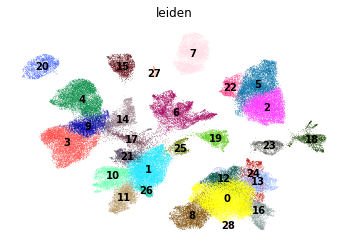

In [56]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")

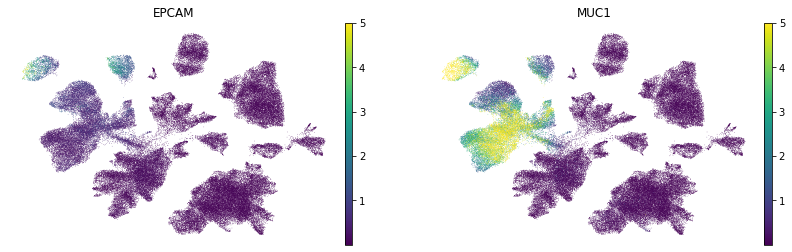

In [155]:
sc.pl.umap(adata, color = ['EPCAM', 'MUC1'], frameon = False, layer = 'scvi_normalized', vmax = 5)
#, layer = 'scvi_normalized'

In [156]:
cell_type = {"0":"Macrophage",
"1":"Fibroblast",
"2":"CD4+ T-cell",
"3":"AT2",
"4":"AT1",
"5":"CD8+ T-cell",
"6":"Endothelial cell",
"7":"Plasma cell",
"8":"Macrophage",
"9":"AT2",
"10":"Fibroblast",
"11":"Fibroblast",
"12":"Macrophage",
"13":"Macrophage",
"14":"Airway epithelial",
"15":"Airway epithelial",
"16":"Monocyte",
"17":"Airway epithelial",
"18":"B-cell",
"19":"Aerocyte",
"20":"Airway epithelial",
"21":"Smooth muscle cell",
"22":"Cycling T/NK",
"23":"Neuronal cell",
"24":"Denditic cell",
"25":"Pericyte",
"26":"Fibroblast",
"27":"Erythroid-like",
"28":"Macrophage"
}


In [160]:
adata.obs['cell type'] = adata.obs.leiden.map(cell_type)

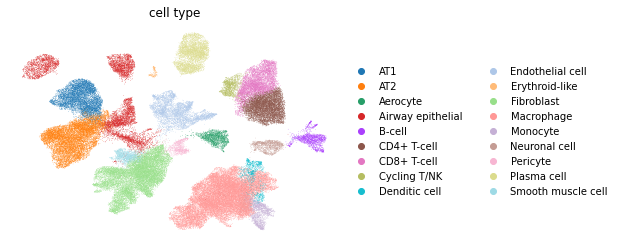

In [162]:
sc.pl.umap(adata, color = ['cell type'], frameon = False)

In [163]:
adata

AnnData object with n_obs × n_vars = 98979 × 20631
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell type'
    var: 'n_cells'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors', 'rank_genes_groups', 'cell type_colors'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [165]:
adata.uns['scvi_markers'] = markers_scvi
adata.uns['markers'] = markers

In [166]:
adata.write_h5ad('integrated.h5ad')

In [167]:
model.save('model.model')

# Analysis

In [1]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

Global seed set to 0


## Counting cells

In [2]:
adata = sc.read_h5ad('integrated.h5ad')

In [4]:
adata.obs.Sample.unique().tolist()

['L08cov',
 'C54ctr',
 'C53ctr',
 'L01cov',
 'L11cov',
 'C52ctr',
 'L09cov',
 'C55ctr',
 'C51ctr',
 'L16cov',
 'L07cov',
 'L04cov',
 'L12cov',
 'L06cov',
 'L17cov',
 'L18cov',
 'L15cov',
 'L05cov',
 'L13cov',
 'L19cov',
 'C57ctr',
 'L10cov',
 'L21cov',
 'L04covaddon',
 'L03cov',
 'C56ctr',
 'L22cov']

In [5]:
def map_condition(x):
    if 'cov' in x:
        return 'COVID19'
    else:
        return 'control'

In [6]:
adata.obs['condition'] = adata.obs.Sample.map(map_condition)
adata.obs

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,_scvi_batch,_scvi_labels,leiden,_scvi_raw_norm_scaling,cell type,condition
TTTGACTAGAGCCGAT-1_15,L08cov,False,2576,2576,5714.0,0.0,0.0,1.0,0.017501,0,0,4,1.754386,AT1,COVID19
TTAGTCTGTATTTCCT-1_15,L08cov,False,2546,2546,5608.0,0.0,0.0,19.0,0.338802,0,0,9,1.787630,AT2,COVID19
AGGCATTCAGCTACAT-1_15,L08cov,False,2527,2527,5431.0,0.0,0.0,0.0,0.000000,0,0,15,1.843998,Airway epithelial,COVID19
GGTGATTAGAGGATCC-1_15,L08cov,False,2531,2531,5489.0,0.0,0.0,0.0,0.000000,0,0,9,1.827819,AT2,COVID19
CAGTTCCGTAGCACAG-1_15,L08cov,False,2503,2503,5446.0,0.0,0.0,10.0,0.183621,0,0,1,1.840604,Fibroblast,COVID19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCTAAGAAGTTGTCAC-1_27,L22cov,False,344,344,413.0,0.0,0.0,0.0,0.000000,0,0,1,24.213076,Fibroblast,COVID19
CGTGAATCATGTCTAG-1_27,L22cov,False,350,350,402.0,0.0,0.0,0.0,0.000000,0,0,0,24.937656,Macrophage,COVID19
GCCGATGAGTAAACGT-1_27,L22cov,False,326,326,401.0,0.0,0.0,8.0,1.995013,0,0,3,25.000000,AT2,COVID19
AGGGTGAGTATCAGGG-1_27,L22cov,False,331,331,402.0,0.0,0.0,0.0,0.000000,0,0,9,24.937656,AT2,COVID19


In [8]:
num_tot_cells = adata.obs.groupby(['Sample']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.doublet))
num_tot_cells

{'C51ctr': 5414,
 'C52ctr': 4062,
 'C53ctr': 6114,
 'C54ctr': 3937,
 'C55ctr': 5107,
 'C56ctr': 3655,
 'C57ctr': 4303,
 'L01cov': 2719,
 'L03cov': 3614,
 'L04cov': 3077,
 'L04covaddon': 3947,
 'L05cov': 2451,
 'L06cov': 5716,
 'L07cov': 4335,
 'L08cov': 3480,
 'L09cov': 3135,
 'L10cov': 1343,
 'L11cov': 2481,
 'L12cov': 3230,
 'L13cov': 4305,
 'L15cov': 3578,
 'L16cov': 1608,
 'L17cov': 4020,
 'L18cov': 2425,
 'L19cov': 2151,
 'L21cov': 2964,
 'L22cov': 5808}

In [11]:
cell_type_counts = adata.obs.groupby(['Sample', 'condition', 'cell type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()
cell_type_counts = cell_type_counts[cell_type_counts.columns[0:4]]
cell_type_counts

,Sample,condition,cell type,doublet
0,C51ctr,control,AT1,743
1,C51ctr,control,AT2,706
2,C51ctr,control,Aerocyte,26
3,C51ctr,control,Airway epithelial,401
4,C51ctr,control,B-cell,39
...,...,...,...,...
445,L22cov,COVID19,Monocyte,127
446,L22cov,COVID19,Neuronal cell,7
447,L22cov,COVID19,Pericyte,60
448,L22cov,COVID19,Plasma cell,519


In [13]:
cell_type_counts['total_cells'] = cell_type_counts.Sample.map(num_tot_cells).astype(int)

cell_type_counts['frequency'] = cell_type_counts.doublet / cell_type_counts.total_cells

cell_type_counts

,Sample,condition,cell type,doublet,total_cells,frequency
0,C51ctr,control,AT1,743,5414,0.137237
1,C51ctr,control,AT2,706,5414,0.130403
2,C51ctr,control,Aerocyte,26,5414,0.004802
3,C51ctr,control,Airway epithelial,401,5414,0.074067
4,C51ctr,control,B-cell,39,5414,0.007204
...,...,...,...,...,...,...
445,L22cov,COVID19,Monocyte,127,5808,0.021866
446,L22cov,COVID19,Neuronal cell,7,5808,0.001205
447,L22cov,COVID19,Pericyte,60,5808,0.010331
448,L22cov,COVID19,Plasma cell,519,5808,0.089360


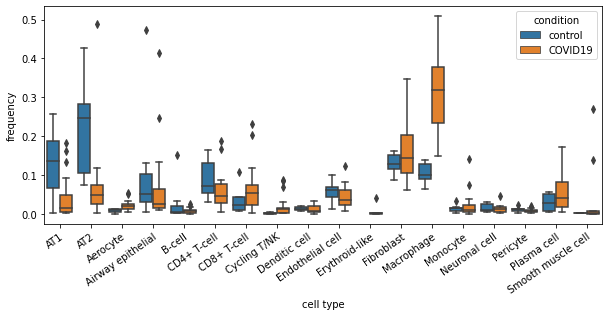

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,4))

ax = sns.boxplot(data = cell_type_counts, x = 'cell type', y = 'frequency', hue = 'condition')

plt.xticks(rotation = 35, rotation_mode = 'anchor', ha = 'right')

plt.show()


## DE

In [16]:
subset = adata[adata.obs['cell type'].isin(['AT1', 'AT2'])].copy()

In [17]:
#two options: SCVI or diffxpy

In [18]:
import diffxpy.api as de

In [19]:
subset.X = subset.X.toarray()

In [20]:
len(subset.var)

20631

In [21]:
subset

AnnData object with n_obs × n_vars = 17392 × 20631
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell type', 'condition'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell type_colors', 'leiden', 'leiden_colors', 'log1p', 'markers', 'neighbors', 'rank_genes_groups', 'scvi_markers', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [22]:
sc.pp.filter_genes(subset, min_cells=100)

In [23]:
len(subset.var)

12705

In [25]:
subset.obs = subset.obs.rename(columns = {'cell type':'cell_type'})

In [ ]:
#subset = subset.raw.to_adata() #need to run this if you scaled/regress your data and have negative numbers


In [26]:
subset.obs

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,_scvi_batch,_scvi_labels,leiden,_scvi_raw_norm_scaling,cell_type,condition
TTTGACTAGAGCCGAT-1_15,L08cov,False,2576,2576,5714.0,0.0,0.0,1.0,0.017501,0,0,4,1.754386,AT1,COVID19
TTAGTCTGTATTTCCT-1_15,L08cov,False,2546,2546,5608.0,0.0,0.0,19.0,0.338802,0,0,9,1.787630,AT2,COVID19
GGTGATTAGAGGATCC-1_15,L08cov,False,2531,2531,5489.0,0.0,0.0,0.0,0.000000,0,0,9,1.827819,AT2,COVID19
GTTCCGTAGACCCGCT-1_15,L08cov,False,2295,2295,5465.0,0.0,0.0,3.0,0.054895,0,0,4,1.832845,AT1,COVID19
CAGATTGCACTAACCA-1_15,L08cov,False,2287,2287,5184.0,0.0,0.0,0.0,0.000000,0,0,4,1.932741,AT1,COVID19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGCTTCCAGGCATGCA-1_27,L22cov,False,360,360,407.0,0.0,0.0,0.0,0.000000,0,0,9,24.570024,AT2,COVID19
GCACGGTCAGAAGTTA-1_27,L22cov,False,336,336,402.0,0.0,0.0,0.0,0.000000,0,0,9,24.937656,AT2,COVID19
TTGTGGATCATAGGCT-1_27,L22cov,False,329,329,406.0,0.0,0.0,1.0,0.246305,0,0,9,24.752476,AT2,COVID19
GCCGATGAGTAAACGT-1_27,L22cov,False,326,326,401.0,0.0,0.0,8.0,1.995013,0,0,3,25.000000,AT2,COVID19


In [27]:
#if want to test between covid/non covid
# res = de.test.wald(data=subset,
#              formula_loc= '~ 1 + condition',
#              factor_loc_totest='condition'
#                   )


res = de.test.wald(data=subset,
             formula_loc= '~ 1 + cell_type',
             factor_loc_totest='cell_type'
                  )

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/batchglm/models/base_glm/utils.py:110: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  np.mean(x[np.where(grouping == g)[0], :], axis=0)
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/batchglm/models/base_glm/utils.py:158: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...

training location model: False
training scale model: True
iter   0: ll=282285631.378020
iter   1: ll=282285631.378020, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=69842680.056717, converged: 0.00% (loc: 0.00%, scale update: True), in 111.34sec
iter   3: ll=69842680.056717, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=69603570.800810, converged: 99.80% (loc: 99.80%, scale update: True), in 107.80sec
iter   5: ll=69603570.800810, converged: 99.80% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=69581454.822264, converged: 99.94% (loc: 99.94%, scale update: True), in 35.62sec
iter   7: ll=69581454.822264, converged: 99.94% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=69551673.109277, converged: 99.98% (loc: 99.98%, scale update: True), in 29.51sec
iter   9: ll=69551673.109277, converged: 99.98% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=69521627.923244, converged: 99.99% (loc:

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/dask/array/core.py:3097: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


In [35]:
dedf = res.summary().sort_values('log2fc', ascending = False).reset_index(drop = True)
dedf

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,AC018359.1,0.000000e+00,0.000000e+00,283.913085,0.014774,False,1.471862e-02,283.913085,2.222759e-162,-2038.835727
1,COL11A1,0.000000e+00,0.000000e+00,283.913085,0.018803,False,1.816848e-02,283.913085,2.222759e-162,-2527.167941
2,AC079015.1,0.000000e+00,0.000000e+00,283.913085,0.020568,False,2.069841e-02,283.913085,2.222759e-162,-2861.828587
3,LINC01584,0.000000e+00,0.000000e+00,283.913085,0.034148,False,3.242799e-02,283.913085,2.222759e-162,-4523.540856
4,AL358335.2,0.000000e+00,0.000000e+00,283.913085,0.013112,False,1.241874e-02,283.913085,2.222759e-162,-1731.587302
...,...,...,...,...,...,...,...,...,...,...
12700,AC095050.1,1.162741e-83,1.762842e-82,-6.081826,0.155194,False,1.322622e-08,-6.081826,3.138373e-01,-5165.938157
12701,SEMA3E,0.000000e+00,0.000000e+00,-297.776029,0.089118,False,1.486194e-08,-297.776029,2.222759e-162,-3373.322329
12702,LINC02814,0.000000e+00,0.000000e+00,-297.776029,0.018353,False,4.406181e-10,-297.776029,2.222759e-162,-962.055118
12703,AL807742.1,0.000000e+00,0.000000e+00,-297.776029,0.023837,False,5.994505e-10,-297.776029,2.222759e-162,-1201.275625


In [30]:
subset.obs.cell_type.unique()

['AT1', 'AT2']
Categories (2, object): ['AT1', 'AT2']

In [31]:
most_up = dedf.iloc[0].gene
i = np.where(subset.var_names == most_up)[0][0]

a = subset[subset.obs.cell_type == 'AT1'].X[:, i]
b = subset[subset.obs.cell_type == 'AT2'].X[:, i]
print(f"{most_up} expression:")
print(f"AT1: {a.mean()}")
print(f"AT2: {b.mean()}")


AC018359.1 expression:
AT1: 0.0
AT2: 0.02354462631046772


In [36]:
dedf['log2fc'] = dedf['log2fc']*-1
dedf = dedf.sort_values('log2fc', ascending = False).reset_index(drop = True)
dedf

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,AC105914.2,0.000000e+00,0.000000e+00,297.776029,0.014490,False,1.973365e-11,-297.776029,2.222759e-162,-794.845097
1,AL807742.1,0.000000e+00,0.000000e+00,297.776029,0.023837,False,5.994505e-10,-297.776029,2.222759e-162,-1201.275625
2,LINC02814,0.000000e+00,0.000000e+00,297.776029,0.018353,False,4.406181e-10,-297.776029,2.222759e-162,-962.055118
3,SEMA3E,0.000000e+00,0.000000e+00,297.776029,0.089118,False,1.486194e-08,-297.776029,2.222759e-162,-3373.322329
4,AC095050.1,1.162741e-83,1.762842e-82,6.081826,0.155194,False,1.322622e-08,-6.081826,3.138373e-01,-5165.938157
...,...,...,...,...,...,...,...,...,...,...
12700,AC079015.1,0.000000e+00,0.000000e+00,-283.913085,0.020568,False,2.069841e-02,283.913085,2.222759e-162,-2861.828587
12701,COL11A1,0.000000e+00,0.000000e+00,-283.913085,0.018803,False,1.816848e-02,283.913085,2.222759e-162,-2527.167941
12702,AL358335.2,0.000000e+00,0.000000e+00,-283.913085,0.013112,False,1.241874e-02,283.913085,2.222759e-162,-1731.587302
12703,LGI3,0.000000e+00,0.000000e+00,-283.913085,0.021436,False,2.092837e-02,283.913085,2.222759e-162,-2906.469822


In [37]:
dedf = dedf[(dedf.qval < 0.05) & (abs(dedf.log2fc) > .5)]
dedf

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,AC105914.2,0.000000e+00,0.000000e+00,297.776029,0.014490,False,1.973365e-11,-297.776029,2.222759e-162,-794.845097
1,AL807742.1,0.000000e+00,0.000000e+00,297.776029,0.023837,False,5.994505e-10,-297.776029,2.222759e-162,-1201.275625
2,LINC02814,0.000000e+00,0.000000e+00,297.776029,0.018353,False,4.406181e-10,-297.776029,2.222759e-162,-962.055118
3,SEMA3E,0.000000e+00,0.000000e+00,297.776029,0.089118,False,1.486194e-08,-297.776029,2.222759e-162,-3373.322329
4,AC095050.1,1.162741e-83,1.762842e-82,6.081826,0.155194,False,1.322622e-08,-6.081826,3.138373e-01,-5165.938157
...,...,...,...,...,...,...,...,...,...,...
12700,AC079015.1,0.000000e+00,0.000000e+00,-283.913085,0.020568,False,2.069841e-02,283.913085,2.222759e-162,-2861.828587
12701,COL11A1,0.000000e+00,0.000000e+00,-283.913085,0.018803,False,1.816848e-02,283.913085,2.222759e-162,-2527.167941
12702,AL358335.2,0.000000e+00,0.000000e+00,-283.913085,0.013112,False,1.241874e-02,283.913085,2.222759e-162,-1731.587302
12703,LGI3,0.000000e+00,0.000000e+00,-283.913085,0.021436,False,2.092837e-02,283.913085,2.222759e-162,-2906.469822


In [38]:
dedf = dedf[dedf['mean'] > 0.15]
dedf

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
4,AC095050.1,1.162741e-83,1.762842e-82,6.081826,0.155194,False,1.322622e-08,-6.081826,0.313837,-5165.938157
7,NCKAP5-AS2,2.313156e-168,6.619064e-167,5.859465,0.273974,False,1.930704e-09,-5.859465,0.211864,-7500.659488
9,RGCC,5.424794e-217,2.051250e-215,5.321312,0.255538,False,1.417977e-09,-5.321312,0.169243,-7263.808007
13,AL355499.1,0.000000e+00,0.000000e+00,5.223264,0.561619,False,1.075236e-09,-5.223264,0.107791,-11323.233400
17,AC022325.2,0.000000e+00,0.000000e+00,4.943113,0.499731,False,9.288125e-11,-4.943113,0.100757,-10848.540222
...,...,...,...,...,...,...,...,...,...,...
12685,HHIP,3.449008e-86,5.389871e-85,-5.207289,0.260891,False,1.157253e-10,5.207289,0.264649,-8370.357374
12689,AC096531.2,5.381522e-201,1.899229e-199,-5.387216,0.679850,False,1.012193e-10,5.387216,0.178096,-15810.527889
12691,LINC01811,2.052466e-62,2.464705e-61,-5.463941,0.219332,False,3.030598e-08,5.463941,0.327708,-7109.339800
12695,PTGFR,3.909067e-69,5.104285e-68,-5.683710,0.276595,False,9.620706e-10,5.683710,0.323419,-9091.070476


In [40]:
genes_to_show = dedf[-25:].gene.tolist() + dedf[:25].gene.tolist() #top 25 and bottom 25 from sorted df

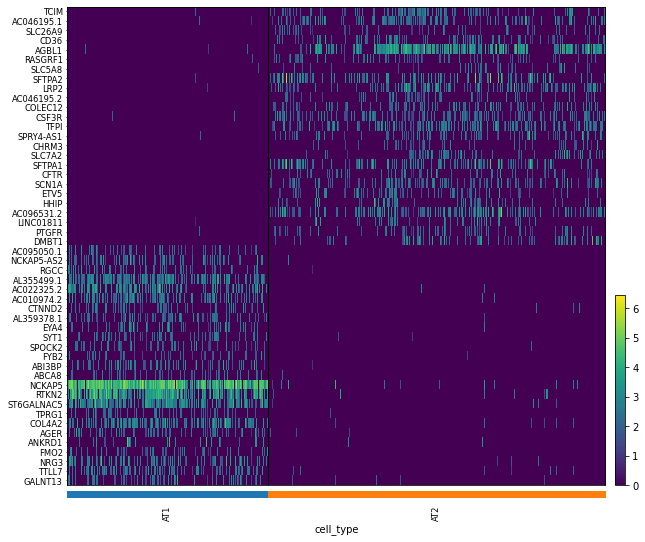

In [41]:
sc.pl.heatmap(subset, genes_to_show, groupby='cell_type', swap_axes=True)

In [ ]:
#DE with scvi

In [42]:
model  = scvi.model.SCVI.load('model.model', adata)

INFO     File model.model/model.pt already downloaded                                        
adfsdfsdf
adfsdfsdf
adfsdfsdf
adfsdfsdf


In [43]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

In [45]:
scvi_de = model.differential_expression(
    idx1 = [adata.obs['cell type'] == 'AT1'],
    idx2 = [adata.obs['cell type'] == 'AT2']
    )

#any set of cells vs any set of cells
# scvi_de = model.differential_expression(
#     idx1 = [(adata.obs['cell type'].isin(['AT1', 'AT2'])) & (adata.obs.condition == 'COVID19')],
#     idx2 = [(adata.obs['cell type'].isin(['AT1', 'AT2'])) & (adata.obs.condition == 'control')]
#     )

DE...: 100%|██████████████████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


In [46]:
scvi_de

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
DMBT1,0.9982,0.0018,6.318161,0.000004,4.513010e-04,0.0,0.25,-8.036115,-8.050153,3.126623,-17.124987,3.295891,0.000772,0.652699,0.000772,0.216806,0.004793,4.311816,True
WNT3A,0.9982,0.0018,6.318161,0.000082,1.773648e-06,0.0,0.25,6.408226,6.574142,2.301937,-2.184126,12.912475,0.115296,0.002108,0.098935,0.002108,0.817271,0.011588,True
AL355499.1,0.9980,0.0020,6.212601,0.000897,1.932020e-05,0.0,0.25,6.727534,6.930730,2.437289,-4.308558,14.008843,1.323336,0.008430,0.556104,0.004307,9.164151,0.028797,True
AC105914.2,0.9980,0.0020,6.212601,0.000014,1.589177e-07,0.0,0.25,6.372631,6.558585,2.219326,-2.153578,13.018692,0.019293,0.000000,0.018521,0.000000,0.148828,0.000000,True
TTLL7,0.9978,0.0022,6.117091,0.000360,2.404536e-05,0.0,0.25,4.069274,4.183637,1.283290,-1.938815,8.505215,0.559035,0.014387,0.354839,0.012554,4.009957,0.078429,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ARID2,0.3742,0.6258,-0.514240,0.000191,1.930834e-04,0.0,0.25,-0.014206,-0.013475,0.281394,-1.349488,1.011988,0.314557,0.324474,0.246643,0.253276,2.150865,2.113666,False
SENP6,0.3694,0.6306,-0.534792,0.000317,3.276030e-04,0.0,0.25,-0.054595,-0.034585,0.296423,-2.012589,1.205351,0.472144,0.538348,0.342028,0.371667,3.274352,3.527349,False
TRIP12,0.3604,0.6396,-0.573628,0.000196,2.121055e-04,0.0,0.25,-0.115991,-0.112569,0.259490,-1.197508,0.898626,0.321503,0.357280,0.256521,0.275818,2.170178,2.294853,False
SNW1,0.3594,0.6406,-0.577969,0.000041,4.309067e-05,0.0,0.25,-0.053936,-0.056183,0.267382,-1.019018,1.037309,0.063127,0.067443,0.060040,0.062952,0.438933,0.430199,False


In [47]:
scvi_de = scvi_de[(scvi_de['is_de_fdr_0.05']) & (abs(scvi_de.lfc_mean) > .5)]
scvi_de = scvi_de.sort_values('lfc_mean')
scvi_de

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
AC096531.2,0.9972,0.0028,5.875328,5.579448e-06,7.901783e-04,0.0,0.25,-8.643203,-9.043480,2.897235,-15.816298,3.244891,0.002933,0.997323,0.002778,0.408870,0.021904,6.957193,True
DMBT1,0.9982,0.0018,6.318161,3.602960e-06,4.513010e-04,0.0,0.25,-8.036115,-8.050153,3.126623,-17.124987,3.295891,0.000772,0.652699,0.000772,0.216806,0.004793,4.311816,True
CHI3L1,0.9942,0.0058,5.144079,6.746318e-07,3.074286e-05,0.0,0.25,-7.818566,-8.191303,3.449313,-16.311127,6.329714,0.000309,0.052232,0.000309,0.038578,0.001423,0.316771,True
SLC26A9,0.9972,0.0028,5.875328,4.452664e-06,1.697237e-04,0.0,0.25,-7.314053,-7.620886,2.954999,-14.140657,4.266300,0.003241,0.217261,0.002933,0.163750,0.021548,1.435716,True
TMEM163,0.9972,0.0028,5.875328,3.144645e-05,1.178261e-03,0.0,0.25,-7.183823,-7.374844,2.857690,-14.284339,3.777314,0.041827,1.918456,0.028245,0.650692,0.241671,13.034749,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCKAP5,0.9972,0.0028,5.875328,7.764196e-03,1.420981e-04,0.0,0.25,6.607409,6.853317,2.110482,-2.175611,14.047405,12.053660,0.071200,0.909400,0.031889,85.427116,0.441436,True
ROR1-AS1,0.9932,0.0068,4.984008,1.136595e-04,3.062625e-06,0.0,0.25,6.704617,6.773970,3.089791,-3.487330,15.579724,0.192315,0.001191,0.133045,0.001008,1.244170,0.003307,True
AL355499.1,0.9980,0.0020,6.212601,8.970711e-04,1.932020e-05,0.0,0.25,6.727534,6.930730,2.437289,-4.308558,14.008843,1.323336,0.008430,0.556104,0.004307,9.164151,0.028797,True
LINC02814,0.9922,0.0078,4.845800,2.117875e-05,1.924546e-07,0.0,0.25,6.823726,6.673983,3.335244,-4.505098,17.230522,0.026084,0.000000,0.023152,0.000000,0.199174,0.000000,True


In [48]:
scvi_de = scvi_de[(scvi_de.raw_normalized_mean1 > .5) | (scvi_de.raw_normalized_mean2 > .5)]
scvi_de

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
AC096531.2,0.9972,0.0028,5.875328,0.000006,0.000790,0.0,0.25,-8.643203,-9.043480,2.897235,-15.816298,3.244891,0.002933,0.997323,0.002778,0.408870,0.021904,6.957193,True
DMBT1,0.9982,0.0018,6.318161,0.000004,0.000451,0.0,0.25,-8.036115,-8.050153,3.126623,-17.124987,3.295891,0.000772,0.652699,0.000772,0.216806,0.004793,4.311816,True
SLC26A9,0.9972,0.0028,5.875328,0.000004,0.000170,0.0,0.25,-7.314053,-7.620886,2.954999,-14.140657,4.266300,0.003241,0.217261,0.002933,0.163750,0.021548,1.435716,True
TMEM163,0.9972,0.0028,5.875328,0.000031,0.001178,0.0,0.25,-7.183823,-7.374844,2.857690,-14.284339,3.777314,0.041827,1.918456,0.028245,0.650692,0.241671,13.034749,True
SFTPA2,0.9922,0.0078,4.845800,0.000031,0.000934,0.0,0.25,-6.708822,-6.964661,3.086403,-14.845112,6.670041,0.014663,1.572346,0.005093,0.311922,0.077923,9.062412,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RTKN2,0.9946,0.0054,5.215940,0.002426,0.000066,0.0,0.25,6.590954,6.739971,2.703112,-4.828271,14.277027,3.802398,0.070558,0.702115,0.018602,27.734455,0.331616,True
NCKAP5,0.9972,0.0028,5.875328,0.007764,0.000142,0.0,0.25,6.607409,6.853317,2.110482,-2.175611,14.047405,12.053660,0.071200,0.909400,0.031889,85.427116,0.441436,True
ROR1-AS1,0.9932,0.0068,4.984008,0.000114,0.000003,0.0,0.25,6.704617,6.773970,3.089791,-3.487330,15.579724,0.192315,0.001191,0.133045,0.001008,1.244170,0.003307,True
AL355499.1,0.9980,0.0020,6.212601,0.000897,0.000019,0.0,0.25,6.727534,6.930730,2.437289,-4.308558,14.008843,1.323336,0.008430,0.556104,0.004307,9.164151,0.028797,True


In [49]:
genes_to_show = scvi_de[-25:].index.tolist() + scvi_de[:25].index.tolist() #top 25 and bottom 25 from sorted df


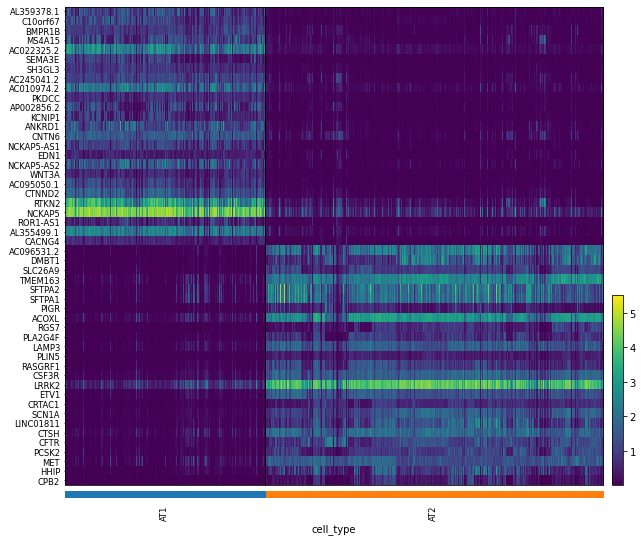

In [50]:

sc.pl.heatmap(subset, genes_to_show, groupby='cell_type', swap_axes=True, layer = 'scvi_normalized',
              log = True)

# GO enrichment

In [51]:
import gseapy as gp #this method requires internet connection

In [52]:
gp.get_library_name()
# 'GO_Biological_Process_2021',
#'KEGG_2021_Human',

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbations_GEO_2022',
 'DisGeNET',
 'Disease_

In [53]:
subset

AnnData object with n_obs × n_vars = 17392 × 12705
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell_type', 'condition'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell type_colors', 'leiden', 'leiden_colors', 'log1p', 'markers', 'neighbors', 'rank_genes_groups', 'scvi_markers', 'umap', 'cell_type_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [58]:
enr = gp.enrichr(gene_list= dedf[dedf.log2fc > 0].gene.tolist(),
                 gene_sets=['KEGG_2021_Human','GO_Biological_Process_2021'],
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = subset.var_names.tolist()
                )

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


In [59]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Focal adhesion,29/201,7.316495e-14,1.785225e-11,0,0,6.602599,199.702610,ITGB1;LAMA5;LAMA3;LAMC2;PIK3R1;ARHGAP5;IGF1R;E...
1,KEGG_2021_Human,Adherens junction,14/71,3.522079e-09,4.296936e-07,0,0,9.389902,182.767065,FARP2;ACTN1;LMO7;ACTN4;PTPRF;RHOA;IGF1R;TJP1;A...
2,KEGG_2021_Human,ECM-receptor interaction,14/88,6.269589e-08,5.099265e-06,0,0,7.226431,119.850144,ITGB1;LAMA5;LAMB3;ITGA3;ITGA2;LAMA3;LAMC2;HSPG...
3,KEGG_2021_Human,Tight junction,19/169,9.770140e-08,5.447448e-06,0,0,4.867223,78.563555,ITGB1;ACTN1;RDX;ACTN4;CGN;PRKCZ;RHOA;TJP1;AFDN...
4,KEGG_2021_Human,Small cell lung cancer,14/92,1.116280e-07,5.447448e-06,0,0,6.854432,109.726383,ITGB1;LAMA5;LAMB3;ITGA3;ITGA2;LAMA3;LAMC2;PIK3...
...,...,...,...,...,...,...,...,...,...,...
2894,GO_Biological_Process_2021,gene expression (GO:0010467),3/356,9.956803e-01,9.971826e-01,0,0,0.313170,0.001356,TSPAN5;BICD1;RBMS2
2895,GO_Biological_Process_2021,translation (GO:0006412),1/214,9.966190e-01,9.977464e-01,0,0,0.173601,0.000588,EEF2K
2896,GO_Biological_Process_2021,"transcription, DNA-templated (GO:0006351)",1/221,9.971957e-01,9.979474e-01,0,0,0.168016,0.000472,MED4
2897,GO_Biological_Process_2021,cellular macromolecule biosynthetic process (G...,2/314,9.977853e-01,9.981612e-01,0,0,0.236267,0.000524,EEF2K;RPA3


## comparisons

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


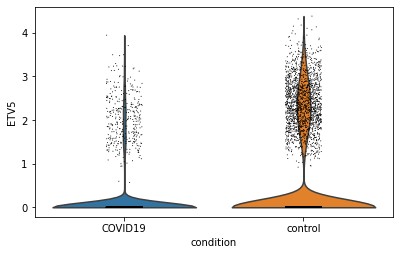

In [60]:
sc.pl.violin(subset[subset.obs.cell_type == 'AT2'], 'ETV5', groupby='condition')

In [61]:
from scipy import stats

In [62]:
temp = subset[subset.obs.cell_type == 'AT2']

i = np.where(temp.var_names == 'ETV5')[0][0]

In [64]:
a = temp[temp.obs.condition == 'COVID19'].X[:,i]
b = temp[temp.obs.condition == 'control'].X[:,i]

In [66]:
stats.mannwhitneyu(a, b)

MannwhitneyuResult(statistic=11610070.0, pvalue=2.7473453476664947e-108)

## Score gene signature

In [67]:
#gene signature, ie, input list of genes from user
with open('datp_sig.txt') as f:
    datp_sig = [x.strip() for x in list(f)]


In [69]:
sc.tl.score_genes(subset, datp_sig, score_name = 'datp')

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [70]:
subset.obs

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,_scvi_batch,_scvi_labels,leiden,_scvi_raw_norm_scaling,cell_type,condition,datp
TTTGACTAGAGCCGAT-1_15,L08cov,False,2576,2576,5714.0,0.0,0.0,1.0,0.017501,0,0,4,1.754386,AT1,COVID19,0.149879
TTAGTCTGTATTTCCT-1_15,L08cov,False,2546,2546,5608.0,0.0,0.0,19.0,0.338802,0,0,9,1.787630,AT2,COVID19,0.462444
GGTGATTAGAGGATCC-1_15,L08cov,False,2531,2531,5489.0,0.0,0.0,0.0,0.000000,0,0,9,1.827819,AT2,COVID19,0.404560
GTTCCGTAGACCCGCT-1_15,L08cov,False,2295,2295,5465.0,0.0,0.0,3.0,0.054895,0,0,4,1.832845,AT1,COVID19,0.350152
CAGATTGCACTAACCA-1_15,L08cov,False,2287,2287,5184.0,0.0,0.0,0.0,0.000000,0,0,4,1.932741,AT1,COVID19,0.297367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGCTTCCAGGCATGCA-1_27,L22cov,False,360,360,407.0,0.0,0.0,0.0,0.000000,0,0,9,24.570024,AT2,COVID19,0.094823
GCACGGTCAGAAGTTA-1_27,L22cov,False,336,336,402.0,0.0,0.0,0.0,0.000000,0,0,9,24.937656,AT2,COVID19,-0.011838
TTGTGGATCATAGGCT-1_27,L22cov,False,329,329,406.0,0.0,0.0,1.0,0.246305,0,0,9,24.752476,AT2,COVID19,0.064200
GCCGATGAGTAAACGT-1_27,L22cov,False,326,326,401.0,0.0,0.0,8.0,1.995013,0,0,3,25.000000,AT2,COVID19,0.147274


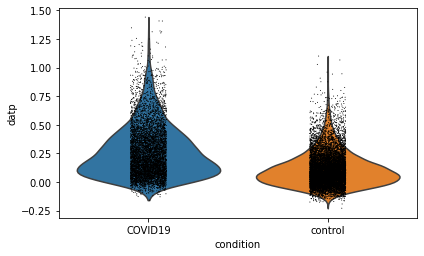

In [71]:
sc.pl.violin(subset, 'datp', groupby='condition')

In [72]:
a = subset[subset.obs.condition == 'COVID19'].obs.datp.values
b = subset[subset.obs.condition == 'control'].obs.datp.values
stats.mannwhitneyu(a, b)

MannwhitneyuResult(statistic=50960539.0, pvalue=0.0)

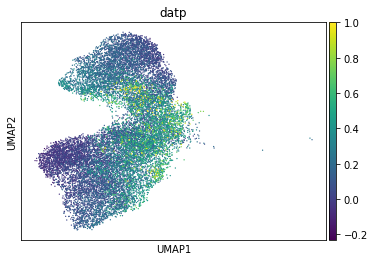

In [75]:
sc.pl.umap(subset, color = 'datp', vmax = 1)

In [3]:
#for thumbnail

In [8]:
from matplotlib.pyplot import rc_context


In [4]:
adata

AnnData object with n_obs × n_vars = 98979 × 20631
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell type'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell type_colors', 'leiden', 'leiden_colors', 'log1p', 'markers', 'neighbors', 'rank_genes_groups', 'scvi_markers', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

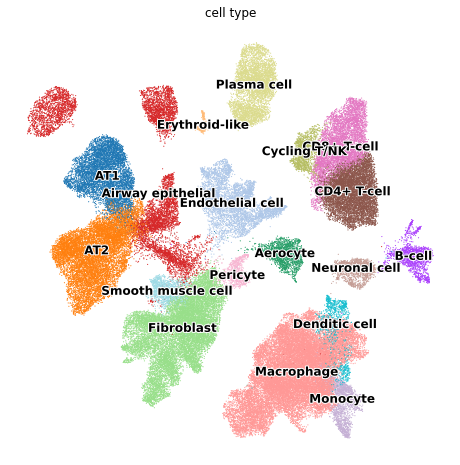

In [19]:
with rc_context({'figure.figsize': (8,8)}):
    sc.pl.umap(adata, color = ['cell type'], frameon = False, s = 5, legend_loc = 'on data',
              legend_fontsize=12, legend_fontoutline=2)

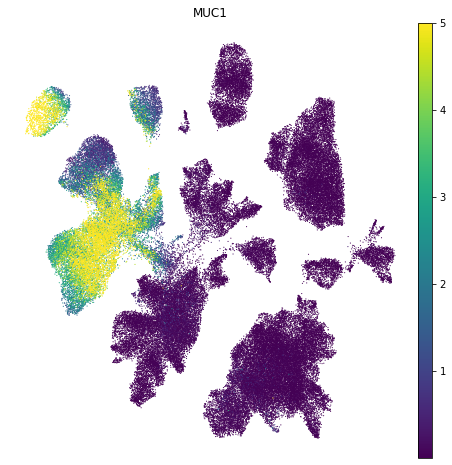

In [14]:
with rc_context({'figure.figsize': (8,8)}):
    sc.pl.umap(adata, color = ['MUC1'], frameon = False, layer = 'scvi_normalized', vmax = 5, s = 5)